# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import scipy.stats as st
import random
from tqdm import tqdm

from model import *
from dataset import *
from utils import *

In [2]:
hyperparams = {
        'n_tasks': 1000,
        'n_episode': 150,
        'n_timesteps': 10,
        'input_dim': 2, 
        'hidden_dim': 512,
        'output_dim': 2,
        'lr': 1e-4,
        'batch_size': 128,
        'n_epochs': 100,
        }

# Load model

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = MyModel(input_dim=hyperparams['input_dim'], hidden_dim=hyperparams['hidden_dim'], output_dim=hyperparams['output_dim']).to(device)
checkpoint = torch.load('Task1_multiTask.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

MyModel(
  (lin1): Linear(in_features=2, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout_for_GD): Dropout(p=0.5, inplace=False)
  (dropout): DropoutLayer()
)

In [4]:
for name, param in model.named_parameters():
	print(name, param.dtype)

lin1.weight torch.float32
lin1.bias torch.float32
lin2.weight torch.float32
lin2.bias torch.float32
lin3.weight torch.float32
lin3.bias torch.float32


# Load data

In [5]:
dataset = torch.load('./two_links_arm_test')
adapt_data = [data['adapt'] for data in dataset]
test_data = [data['test'] for data in dataset]

# Adaptation 

In [44]:
def smcd(model: MyModel, T, N, adapt_data, d=0.5):
	'''
	model: neural network
	T: adaptation timestep
	N: particle numbers
	adapt_data: as name
	d: flip rate
	'''
	q = adapt_data['angle']
	z = adapt_data['noisy_pos']
	n_features = model.get_dropout_mask().shape[0]
	# initialize M_0
	M = np.random.randint(low=0,high=2,size=(n_features, N))
	# M = flip(M)
	assert T <= q.shape[-1], f'T should be less than {q.shape[-1]}'
	assert model.training == False, f'please call model.eval()'
	M_best = []
	for t in tqdm(range(T)):
		M_t = flip(M)
		w = []
		for i in range(N):
			model.update_dropout_mask(M_t[:,i])
			# print(q[t].dtype)
			x_i = model(q[:,t].to(device, dtype=torch.float32)).detach().numpy()
			w_i = st.multivariate_normal.pdf(z[:,t].detach().numpy(), mean = x_i, cov = 0.1)
			w.append(w_i)
		# print(x_i, z[:,t])
		# print(M_t.shape)
		# print(w)
		resample_index = resample(range(N), w)
		M = np.take(M_t, resample_index, axis=1)
		M_t_best = (M.mean(axis=1) > 0.5).astype(np.int_)
		# print(M_t_best.shape)
		M_best.append(M_t_best)
	return M_best 

In [45]:
M_best = smcd(model, 10, 1000, adapt_data[0])

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


In [46]:
q = adapt_data[0]['angle'].to(torch.float32).swapaxes(1,0)
x = adapt_data[0]['true_pos'].to(torch.float32).swapaxes(1,0)
model.update_dropout_mask(M_best[-1])
x_pred = model(q).detach().numpy()

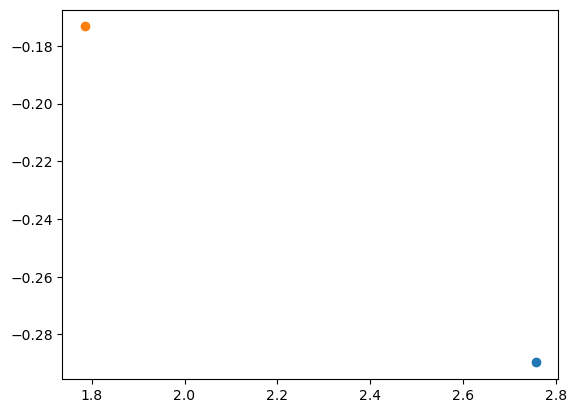

In [47]:
plt.scatter(x[9,0], x[9,1])
plt.scatter(x_pred[9,0], x_pred[9,1])

In [49]:
x_pred[-1], x[-1]

(array([ 0.09739734, -0.45047942], dtype=float32), tensor([-0.2929, -1.0573]))